# pyGMs Introduction: GraphModel

In [1]:
import numpy as np
import pyGMs as gm
import matplotlib.pyplot as plt

Once we have the definition of our random variables, $X_0,...,X_{n-1}$, and factors, we can define a graphical model to be the "combination" of a collection of factors.  Specifically, most probabilistic graphical models are defined by the product of their factors; for example, in Bayesian networks, each factor corresponds to a conditional probability distribution, and the overall joint distribution is defined by the product of these conditionals.

## Bayesian networks
Any probability distribution can be defined in terms of an expansion into conditionals, for example,
$$p(X) = p(X_0,X_1,X_2) = p(X_0) \ p(X_1|X_0) \ p(X_2|X_0,X_1)$$

A Bayesian network imposes assumptions on the probability distribution $p(X)$ by asserting that some of these factors do not depend on all the preceding variables; for example, if $X_2$'s distribution only depends on $X_0$ and not on $X_1$, we can write,
$$p(X_0,X_1,X_2) = p(X_0) \ p(X_1|X_0) \ p(X_2|X_0)$$
in which case we do not need to represent a table over all $d^3$ values $(x_0,x_1,x_2)$, but only a collection of tables over at most $d^2$ values at a time.

Let's define a distribution over five variables, corresponding to a version of the classic "Burglar Alarm" example.  First, we define the variables themselves, which will all take on two possible values (true or false):

In [2]:
B = gm.Var(0,2)   # Was there a burglary at Sherlock Holmes' house?
E = gm.Var(1,2)   # Was there an earthquake?
A = gm.Var(2,2)   # Has the alarm gone off?
W = gm.Var(3,2)   # Has Watson called to complain?
H = gm.Var(4,2)   # Has Mrs Hudson called to complain?

X = [B,E,A,W,H]   # we'll often refer to variables as Xi or X[i]

# sometimes it's useful to have a reverse look-up from ID to "name string" (e.g. when drawing the graph)
IDtoName = dict( (eval(n).label,n) for n in ['B','E','A','W','H'])

Next, we define the conditional probability tables in the model:

In [3]:
p_E = gm.Factor([E], [.998, .002]) # probability of earthquake (false,true)

p_B = gm.Factor([B], [.999, .001]) # probability of burglary

p_A_BE = gm.Factor([A,B,E], 0.0)   # Note: this factor is actually over the *set* {B,E,A}
                                   #   since factors do not save the order of their arguments!
                                   # To index using just tuple notation, we need to know the order of
# Set  B,E,A                       #   the variables ID numbers, in this case: B,E,A
p_A_BE[0,0,:] = [.999, .001]       # ":" refers to an entire row of the table (a "slice" in Python)
p_A_BE[0,1,:] = [.710, .290]       
p_A_BE[1,0,:] = [.060, .940]       # For each setting (b,e), the table should sum to one over A
p_A_BE[1,1,:] = [.050, .950]       #   so that it corresponds to a conditional probability

p_W_A = gm.Factor([A,W], 0.0)      # Probability that Watson calls given the alarm's status
p_W_A[0,:]    = [.95, .05]
p_W_A[1,:]    = [.10, .90]

p_H_A = gm.Factor([A,H], 0.0)      # Probability that Mrs Hudson calls given the alarm's status
p_H_A[0,:]    = [.99, .01]
p_H_A[1,:]    = [.30, .70]

factors = [p_W_A, p_H_A, p_A_BE, p_E, p_B]  # collect all the factors that define the model

We can define a `GraphModel` to contain this collection of probability factors:

In [4]:
model = gm.GraphModel([p_E,p_B,p_A_BE,p_W_A,p_H_A])

`model` now defines an implicit function over all the variables in those factors:

In [5]:
print(model.vars)
print(list(model.factors))        # normally "factors" is a sorted set

[Var (0,2), Var (1,2), Var (2,2), Var (3,2), Var (4,2)]
[Factor({0},[0x1ce7000]), Factor({1},[0x2552a70]), Factor({2,3},[0x2a322b0]), Factor({2,4},[0x2b92cd0]), Factor({0,1,2},[0x2b8b300])]


Our model now **implicitly** defines the function corresponding to the product of these factors.  For example,

In [6]:
print('(0,0,0,0,0): ',model.value( (0,0,0,0,0) ))   # p(BEAWH=00000)

print('(0,1,1,1,0): ',model.value( (0,1,1,1,0) ))   # p(BEAWH=01110)

(0,0,0,0,0):  [0.9367427]
(0,1,1,1,0):  [0.00015644]


We could **explicitly** compute this function using factor operations, e.g.,

In [7]:
p_BEAWH = p_W_A * p_H_A * p_A_BE * p_E * p_B
print('(0,0,0,0,0): ',p_BEAWH[ (0,0,0,0,0) ])
print('(0,1,1,1,0): ',p_BEAWH[ (0,1,1,1,0) ]) 

(0,0,0,0,0):  0.936742700619
(0,1,1,1,0):  0.00015644339999999998


However, the joint, table representation of $p(B,E,A,W,H)$ may be much larger than the individual factors:

In [8]:
print("Full joint size: ", p_BEAWH.numel())
print("Conditional Factor sizes: ", [f.numel() for f in [p_E,p_B,p_A_BE,p_W_A,p_H_A]])

Full joint size:  32
Conditional Factor sizes:  [2, 2, 8, 4, 4]


We often display a Bayesian network using a directed graph, with one node in the graph for each random variable, and the parents of that node in the graph corresponding to the variables that are conditioned on for that variable's term in the conditional expansion.  We can use `networkx` to display a Bayesian network stored as a `GraphModel`:

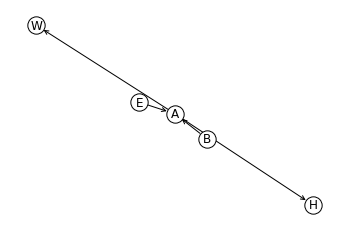

In [9]:
fig,ax=plt.subplots(1,1)
ax.set_axis_off()
gm.drawBayesNet(model,node_color='w',ax=ax, var_labels=IDtoName);

The layout is automatic and can be random; for reproducible results you can specify the node positions explicitly:

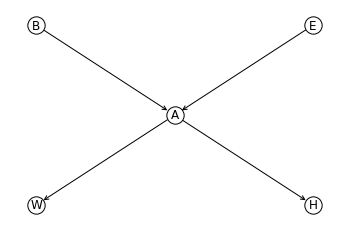

In [10]:
fig,ax=plt.subplots(1,1); ax.set_axis_off();
pos = {0: (-1,0), 1:(1,0), 2:(0,-1), 3:(-1,-2), 4:(1,-2)}  # dict: { i: position of node Xi }
gm.drawBayesNet(model,node_color='w',ax=ax, pos=pos, var_labels=IDtoName);

## Factor Graphs

It's not always the case that the function we want to model is nicely expressed as a sequence of conditional probabilities.  Instead, we may define an unnormalized function that is the product of a collection of smaller factors.  For example, a constraint satisfaction problem can be expressed as a collection of smaller factors corresponding to each constraint.

In [11]:
X = tuple( gm.Var(i,3) for i in range(7) )

not_equal = np.ones((3,3))              # each constraint is over two neighboring variables
for v in range(3): not_equal[v,v] = 0.  # table is zero (forbidden) if both variables are the same value (color)

neighbors = [(X[0],X[1]),(X[0],X[2]),(X[1],X[2]),(X[1],X[3]),(X[2],X[3]),
             (X[2],X[4]),(X[2],X[5]),(X[3],X[4]),(X[4],X[5])]

factors = [gm.Factor( XiXj, not_equal ) for XiXj in neighbors]

csp = gm.GraphModel(factors)

We can then draw the corresponding graph, as either a factor graph (in which the factors are explicitly drawn using squares), or as a Markov random field (in which variables that participate in a factor together are joined by an edge).

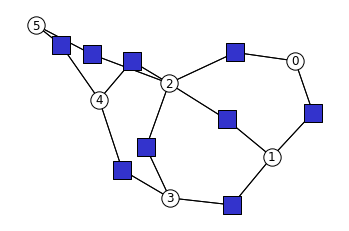

In [12]:
fig,ax=plt.subplots(1,1); ax.set_axis_off()
gm.drawFactorGraph(csp, var_color='w',factor_color=[(.2,.2,.8)]);

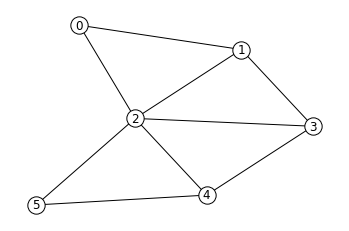

In [13]:
fig,ax=plt.subplots(1,1); ax.set_axis_off()
gm.drawMarkovGraph(csp, node_color='w');

`GraphModel` does not know whether the model we have defined is a Bayesian network or a more general collection of factors.  However, we can try to check to see whether there is a root-to-leaf ordering of the variables, such that each table can be expressed as a normalized conditional distribution.  If so, we can conclude that the model is a Bayesian network:

In [14]:
model.isBN()

True

In [15]:
csp.isBN()

False

## Log Representations

Taking the product of a large collection of numbers tends to become numerically unstable; for example, if the numbers are all probabilities (and so less than one), the products become extremely small as the model size grows and may start to numerically underflow.  For this reason, it is common in practice to represent our model, and its factors, in the log domain.  Then, the product of the original factors is simply the sum of the log-factors.

However, the `GraphModel` functions need to know whether the factors should be interpreted using a product, or a sum (for log factors).  We can tell `GraphModel` which type of factors we are passing in using the `isLog` flag.  After constructing a `GraphModel`, we can convert to log, or back, using `model.toLog()` and `model.toExp()`, and can check which semantics apply using `model.isLog()`:

In [18]:
print('p(0,0,0,0,0)=', model.value( (0,0,0,0,0) ))
print("log form?", model.isLog)

print("\n converting...")
model.toLog()

print('p(0,0,0,0,0)=', model.value( (0,0,0,0,0) )) 
print("log form?", model.isLog)

print(f'Only the internal factors being stored have changed, e.g., f0(X0=0)={model.factors[0][0]}\n')

print("If we convert back...")
model.toExp()   # and convert back

print('p(0,0,0,0,0)=', model.value( (0,0,0,0,0) )) 
print("log form?", model.isLog)
print(f'Again, the overall function is the same, but internally, f0(X0=0)={model.factors[0][0]}')

p(0,0,0,0,0)= [0.9367427]
log form? False

 converting...
p(0,0,0,0,0)= [0.9367427]
log form? True
Only the internal factors being stored have changed, e.g., f0(X0=0)=-0.0010005003335835344

If we convert back...
p(0,0,0,0,0)= [0.9367427]
log form? False
Again, the overall function is the same, but internally, f0(X0=0)=0.999


So, we can make the internal representation be either a product of factors, or a sum of log factors; either way, the  `value` method will compute the same quantity (the product, or exponentiated sum-of-log values).  There is also a corresponding function `logValue` which returns the log of the product, or sum-of-log value, depending on the internal representation.  This allows either internal form to be used without affecting external behavior.

**NOTE:** `toLog()` and `toExp()` operate in-place on the factor tables, and thus require that the model be able to alter those tables.  See notes on `GraphModel.lock`.

## Graph Connectivity

The `GraphModel` acts as a container than allows us to keep track of and query the structure of the graphical model.  The most basic operations we might want are to understand which variables are directly related to which, and how.  We can use accessors to find this information easily.  For example, the Markov blanket of a variable are those that are directly related through some factor, e.g.:

In [19]:
model.markovBlanket( W )

{2}

The Markov blanket of W is simply A; W is conditionally independent of the rest of the model given A.

In [20]:
model.markovBlanket( B )

{1,2}

The Markov blanket of B is E and A; given A, B is independent of W or H, but not (conditinoally) independent of E.

We can explicitly find the factors that contain a variable:

In [21]:
model.factorsWith( B )

SortedSet([Factor({0},[0x1ce7000]), Factor({0,1,2},[0x2b8b300])], key=<function factorSet.<locals>.<lambda> at 0x7f00f72e81f0>)

i.e., the factors corresponding to $p(B)$ and $p(A|E,B)$.

We can also find factors that involve any of a set of variables,

In [22]:
model.factorsWithAny( [B,E] )

SortedSet([Factor({0},[0x1ce7000]), Factor({1},[0x2552a70]), Factor({0,1,2},[0x2b8b300])], key=<function factorSet.<locals>.<lambda> at 0x7f00f49a6e50>)

or the intersection of the sets, i.e., factors with all the provided variables:

In [23]:
model.factorsWithAll( [B,E] )

SortedSet([Factor({0,1,2},[0x2b8b300])], key=<function factorSet.<locals>.<lambda> at 0x7f00f72e81f0>)

## Graph Operations

### Conditioning on values

Another basic operation we would like to perform is to assert, or fix, the value of one or more variables.  
For example, suppose that we would like to understand the implications of knowing that an earthquake has occurred, $E=1$.

We can view this as a transformation on the factors, and thus on the graph.  If we know that $E=1$, we can remove $E$ from each of its factors, resulting in smaller factors that only depend on the other arguments, simplifying the overall graph structure:

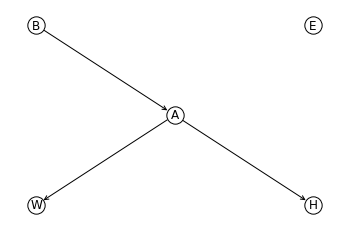

In [24]:
cond_E = model.copy()
cond_E.condition({E:1})

fig,ax=plt.subplots(1,1); ax.set_axis_off();
pos = {0: (-1,0), 1:(1,0), 2:(0,-1), 3:(-1,-2), 4:(1,-2)}  # dict: { i: position of node Xi }
gm.drawBayesNet(cond_E,node_color='w',ax=ax, pos=pos, var_labels=IDtoName);

Although we call this "conditioning", it is sometimes called "clamping", since we are not explicitly computing the conditional distribution $p(B,A,W,H|E=1)$, but rather the partial joint distribution $p(B,E=1,A,W,H)$.  These two functions are equal up to the normalizing constant, $p(E=1)$.

Note also that the graphical model still includes the variable $E$, although it is no longer connected to anything.  The model maintains a single factor over $E$, which has non-zero value only for $E=1$; e.g.,

In [25]:
print("Is currently a Bayes Net? ", cond_E.isBN())
print("We should see a single factor invoving E:")
print(cond_E.factorsWith(E))
print("with table entries,")
print(cond_E.factorsWith(E)[0].table)

Is currently a Bayes Net?  False
We should see a single factor invoving E:
SortedSet([Factor({1},[0x2ef8ac0])], key=<function factorSet.<locals>.<lambda> at 0x7f00f72e8160>)
with table entries,
[0.    0.002]


In other words, the configuration $E=0$ is forbidden (probability zero), while $E=1$ retains the value of this assignment.  In this particular case, re-normalizing the distribution is trivial:

In [26]:
fE = cond_E.factorsWith(E)[0]
fE /= fE.sum()
print("Updated to table entries,")
print(cond_E.factorsWith(E)[0].table)
print("Is now a Bayes Net? ", cond_E.isBN())

Updated to table entries,
[0. 1.]
Is now a Bayes Net?  True


However, this re-normalization can be less trivial when our evidence (conditioned variables) are children of other variables in the Bayesian network, e.g.,

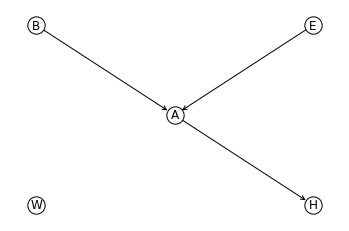

In [27]:
cond_W = model.copy()
cond_W.condition({W:1})

fig,ax=plt.subplots(1,1); ax.set_axis_off();
pos = {0: (-1,0), 1:(1,0), 2:(0,-1), 3:(-1,-2), 4:(1,-2)}  # dict: { i: position of node Xi }
gm.drawBayesNet(cond_W,node_color='w',ax=ax, pos=pos, var_labels=IDtoName);

In this case, the evidence that Watson called, $W=1$, has created an un-normalized factor over the alarm, $A$; normalizing this distribution will involve connecting $B$ and $E$, since $B$ and $E$ are conditionally dependent given the observation.

In [28]:
print("We should see a single factor invoving W:")
print(cond_W.factorsWith(W))
print("with table entries,")
print(cond_W.factorsWith(W)[0].table)
print()
print("But now a factor over only A (the first one in the list),")
print(cond_W.factorsWith(A))
print(cond_W.factorsWith(A)[0].table)
print("corresponding to the function p(W=1|A)")

We should see a single factor invoving W:
SortedSet([Factor({3},[0x2cf83d0])], key=<function factorSet.<locals>.<lambda> at 0x7f00f72e8040>)
with table entries,
[0. 1.]

But now a factor over only A (the first one in the list),
SortedSet([Factor({2},[0x2ef8b00]), Factor({2,4},[0x3001440]), Factor({0,1,2},[0x2482400])], key=<function factorSet.<locals>.<lambda> at 0x7f00f72e80d0>)
[0.05 0.9 ]
corresponding to the function p(W=1|A)


Since the probability of our evidence, $W=1$, depends on the value of $A$ (and thus the rest of the probability distribution), we can no longer simply read it out and re-normalize.

### Variable Elimination
Variable elimination is a form of inference or reasoning in which we remove (eliminate) a variable from our graphical model while leaving the inference quantity of interest unchanged.  For example, we might marginalize out (sum over) a variable, resulting in the marginal probability distribution over the remaining variables. This operation preserves the partition function, or normalizing constant, of the model; for normalized distributions such as Bayesian networks, the resulting model will remain normalized; for unnormalized models (such as the CSP example), the operation preserves the number of possible solutions to the original problem.

To marginalize over a variable $X_i$, we collect the factors that involve that variable, explicitly construct a factor corresponding to their combination (e.g., product), and then marginalize that factor, resulting in a new factor over the neighbors of $X_i$ that replaces the set of collected factors.  The new model no longer contains $X_i$, but may now contain a larger factor than before, depending on $X_i$'s number of neighbors.

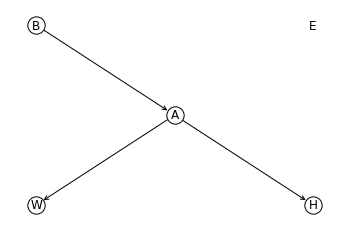

In [29]:
elim_E = model.copy()
elim_E.eliminate([1],'sum')

fig,ax=plt.subplots(1,1); ax.set_axis_off();
pos = {0: (-1,0), 1:(1,0), 2:(0,-1), 3:(-1,-2), 4:(1,-2)}  # dict: { i: position of node Xi }
gm.drawBayesNet(elim_E,node_color='w',ax=ax, pos=pos, var_labels=IDtoName);

Note that the "E" is still drawn, because we explicitly passed it in as a label with a location to `networkx` as part of `IDtoName`; but it is no longer part of the graph itself, and would be left out otherwise.

As with conditioning, our model does not forget the existence of E completely; but unlike conditioning, E does not have a specific value to which it has been assigned.  The model remembers $E$'s label or ID number as a variable, but one which is involved in no factors and takes on only one state (i.e., a trivial random variable).

## Sampling

The factors of a Bayesian network correspond to a sequence of normalized conditional probability distributions, following an order (the Bayesian network's "topological order") from roots to leaves.  This means that sampling from a Bayesian network is particularly easy: we can draw the value of a root; then, conditioned on the values of the root variables, any children of roots can be sampled easily, and so on.  If our model is a Bayesian network, we can sample from it using `bnSample`:

In [30]:
topo_order = gm.bnOrder(model)          # find a topological order, if one exists
x,lnpx = gm.bnSample(model, order=topo_order)    # draw a sample following that order
print("Sampled config: ",x)
print("Log-probability of drawing x:", lnpx)

Sampled config:  (0, 0, 0, 0, 0)
Log-probability of drawing x: -0.06534663357889217


The presence of any conditioned variables in the model means that their sampled values will correspond to their assignment; so if we sample from our representation of $p(B,A,H,W|E=1)$, we still get a complete sample of $X$ in which we are guaranteed to have $E=1$.

In [31]:
x,lnpx = gm.bnSample(cond_E, order=topo_order)    # draw a sample following that order
print("Sampled config: ",x)
print("Log-probability of drawing x:", lnpx)

Sampled config:  (0, 1, 0, 0, 0)
Log-probability of drawing x: -0.40483443952141157


`bnSample` returns both the configuration of the model, and the log-probability; this allows it to be used in algorithms such as forward sampling, that can be applied to Bayesian networks with evidence or other unnormalized graphical models.  If the model is normalized, the returned log-probability is simply $\log p(x)$; however, if the model is un-normalized, the samples are being drawn from some normalized approximation $q(X)$, and the returned value corresponds to this sampling probability, $\log q(x)$.

In [32]:
print("For p(X|E=1), we evaluate directly and find:", cond_E.logValue( x ), ", the same value as was returned.")
print()
      
print("If we attempt to sample from the non-normalized p(X,W=1), we get:")
x,lnpx = gm.bnSample(cond_W, order=topo_order)    # draw a sample following that order
print("  Sampled config: ",x)
print("  Log-probability of drawing x:", lnpx)
print("while the direct evaluation gives:", cond_W.logValue( x ) , ", a different value.")

For p(X|E=1), we evaluate directly and find: [-0.40483444] , the same value as was returned.

If we attempt to sample from the non-normalized p(X,W=1), we get:
  Sampled config:  (0, 0, 1, 1, 1)
  Log-probability of drawing x: -0.4137446682132649
while the direct evaluation gives: [-7.37279324] , a different value.


## Consolidating Factors

In normalized models such as Bayesian networks, there is a specific meaning to each factor, which corresponds to a single variable's conditional distribution.  In undirected models, the factors have no specific meaning; but they are still useful by helping understand the conditional independence of the model.  In the undirected setting, however, it is only the maximal cliques which determine this conditional independence; any smaller factors can be subsumed into a larger factor that contains the same variables.  In `GraphModel`, the `makeMinimal` function will reduce the number of factors using this technique:

In [33]:
makemin = cond_W.copy()
makemin.makeMinimal()
print("Original factors:", list(cond_W.factors))
print("Consolidated factors:", list(makemin.factors))

Original factors: [Factor({0},[0x3000700]), Factor({1},[0x2966150]), Factor({2},[0x2ef8b00]), Factor({3},[0x2cf83d0]), Factor({2,4},[0x3001440]), Factor({0,1,2},[0x2482400])]
Consolidated factors: [Factor({3},[0x2f12030]), Factor({2,4},[0x2f0ad10]), Factor({0,1,2},[0x28eaa50])]


This can be important in some algorithms, such as message passing algorithms, which may behave differently on models that have multiple factors joining a set of variables.

Some message passing algorithms prefer to instead preserve any "singleton" (single-variable) factors, only merging non-singleton factors; we call this the "canonical" representation:

In [34]:
makecan = cond_W.copy()
makecan.makeCanonical()
print("Original factors:", list(cond_W.factors))
print("Canonical factors:", list(makecan.factors))

Original factors: [Factor({0},[0x3000700]), Factor({1},[0x2966150]), Factor({2},[0x2ef8b00]), Factor({3},[0x2cf83d0]), Factor({2,4},[0x3001440]), Factor({0,1,2},[0x2482400])]
Canonical factors: [Factor({0},[0x2b02350]), Factor({1},[0x2f12050]), Factor({2},[0x2f2ac80]), Factor({3},[0x1f466a0]), Factor({2,4},[0x2e345a0]), Factor({0,1,2},[0x24aef10])]


## Saving and Loading Models

The `pyGMs` package supports a number of file formats for representing graphical models.  The most common of these is the ".uai" format, used in inference competitions at the Conference on Uncertainty in Artificial Intelligence (UAI).  The ".uai" format has up to three components: the model factors themselves, which can be read using,

In [35]:
factor_list = gm.readUai('../tests/data/BN_0.uai')
print(f'{len(factor_list)} factors read.')

100 factors read.


and then, for the purpose of defining an inference task, there may be an "evidence file" that includes additional assignments to variables in the model,

In [36]:
evid = gm.readEvidence14('../tests/data/BN_0.uai.evid')
print(f'{len(evid)} variables should be assigned values before inference')

26 variables should be assigned values before inference


and finally, for some tasks (e.g., marginal MAP), there may be a "query" file defining which variables to estimate.

The query file consists of just a list of variable ID numbers, and so uses the same format that `pyGMs` uses for saving and reloading elimination orders, e.g.,

In [38]:
order = [0,1,2,3,4,5]
gm.writeOrder('../tests/data/example.ord', order)
order = gm.readOrder('../tests/data/example.ord')

Other formats that can be read and/or written include:
* Ergo (`readErgo`, `writeErgo`; for Bayesian networks)
* WCSP (`readWCSP`, `writeWCSP`; for weighted constraint satisfaction problems)
* GeNIe XML DSL (`readDSL`; for Bayesian networks)
* LiMID (`readLimid`; Dennis Maua's limited memory influence diagram format)
* LimID CRA (`readLimidCRA`; a slightly different LiMID format from Charles River Analytics)